# CNN backbone + NN regresion model

Libraries

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.nn import functional as F
import timm
import albumentations as A
from tqdm import tqdm

Parameters

In [5]:
# Path control
path = '../input/petfinder-pawpularity-score/'
img_dir = path + 'train/'
label_path = path + 'train.csv'

# Parameters
random_seed = 17
pin_memory = True
num_workers = os.cpu_count()
val_size = 0.2
img_size = 224

#Hiperparameters
NUM_EPOCHS = 4
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
MOMENTUM = 0.9
F_OPTIMIZER = optim.SGD
LOSS_FUNCTION = nn.MSELoss()
MODEL_NAME='tf_efficientnet_b0_ns'

In [6]:
# Transforms from kaggle (look they don't transform into tensor!!!!!!!!)
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(img_size, img_size),
    A.Cutout(max_h_size=int(img_size * 0.375), max_w_size=int(img_size * 0.375), num_holes=1, p=0.7),    
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize()
])

/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1896: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/denis/miniconda3/envs/deepsing/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Setting randomness

In [7]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=random_seed)

Device

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Define pytorch dataset object

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dataframe, img_name, label_name, meta_x, transform=None):
        self.img_dir = img_dir
        self.img_label = label_dataframe
        self.transform = transform
        self.img_name = img_name
        self.label_name = label_name
        self.meta_x = meta_x
        
    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, ix):
        meta_x_ix = self.img_label[self.meta_x].iloc[ix]
        meta_x_ix = torch.tensor(meta_x_ix, dtype=torch.float32)

        img_path = self.img_dir + self.img_label[self.img_name][ix] + '.jpg'
        X_ix = plt.imread(img_path)
        if self.transform:
            X_ix = self.transform(image=X_ix)['image']
        X_ix = torch.tensor(X_ix).permute(2, 0, 1).float()

        Y_ix = self.img_label[self.label_name][ix]
        Y_ix = torch.tensor(Y_ix, dtype=torch.float32)

        return (X_ix, meta_x_ix) , Y_ix

Instances Dataset & Dataloader objects

In [10]:
df = pd.read_csv(label_path)
df['nPawpularity']=(df['Pawpularity'] - df['Pawpularity'].min()) / (df['Pawpularity'].max() - df['Pawpularity'].min())
df_train, df_val = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,nPawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0.626263
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,0.414141
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0.272727
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0.141414
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0.717172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15,0.141414
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70,0.696970
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20,0.191919
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20,0.191919


In [11]:
meta_x_columns = [
    'Subject Focus','Eyes','Face','Near','Action','Accessory', 
    'Group', 'Collage','Human','Occlusion','Info','Blur'
    ]

dataset = {
    'train': Dataset(img_dir, df_train, 'Id', 'Pawpularity', meta_x_columns, transform=transforms_train),
    'val'  : Dataset(img_dir, df_val  , 'Id', 'Pawpularity', meta_x_columns, transform=transforms_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory),
    'val'  : torch.utils.data.DataLoader(dataset['val']  , batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
}

Sample images (to see augmentations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

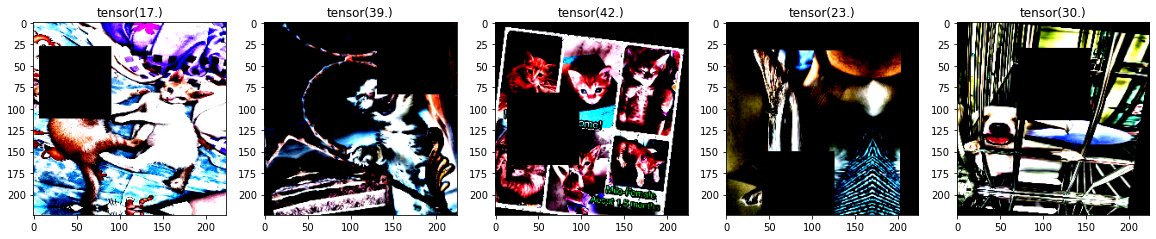

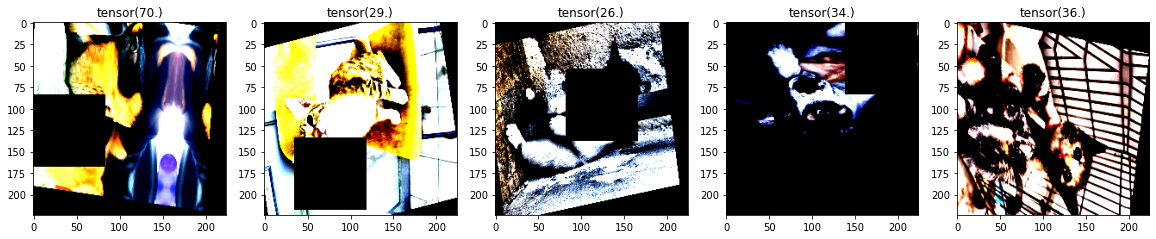

In [13]:
dataset_show = dataset['train']
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img[0]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

Tailored network based on efficientnet

In [9]:
#device = 'cpu'

In [14]:
class BackboneNet(nn.Module):
    def __init__(self, timm_model_name, len_meta_x, out_dim, pretrained=True, freezepretrained=False):
        super().__init__()

        self.efficientmodel = timm.create_model(timm_model_name, pretrained=pretrained)
        n_features = self.efficientmodel.classifier.in_features
        self.efficientmodel.classifier = nn.Identity()
        
        self.metamodel = nn.Sequential(
            nn.Linear(len_meta_x, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(512, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        n_features += 128
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_features, out_dim)

        # freeze weights of efficientnet
        if freezepretrained:
            for param in self.efficientmodel.parameters():
                param.requires_grad = False


    def forward(self, image, meta_x):
        # backbone 1: efficient net
        x1 = self.efficientmodel(image)
        # backbone 2: meta model
        x2 = self.metamodel(meta_x)
        # concatenate backbones
        x = torch.cat((x1, x2), dim=1)
        # head
        x = self.dropout(x)
        x = self.fc(x)
        # drop dimension of size 1 (same as .view(-1)) (if not, broadcasting problems with y ground truth)
        x = x.squeeze()     
        return x

In [15]:
net = BackboneNet(timm_model_name=MODEL_NAME, len_meta_x=12, out_dim=1, pretrained=True, freezepretrained=False)
net.to(device) 

BackboneNet(
  (efficientmodel): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, t

Count total model trainable parameters

In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)

+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|         efficientmodel.conv_stem.weight         |    864     |
|            efficientmodel.bn1.weight            |     32     |
|             efficientmodel.bn1.bias             |     32     |
|     efficientmodel.blocks.0.0.conv_dw.weight    |    288     |
|       efficientmodel.blocks.0.0.bn1.weight      |     32     |
|        efficientmodel.blocks.0.0.bn1.bias       |     32     |
| efficientmodel.blocks.0.0.se.conv_reduce.weight |    256     |
|  efficientmodel.blocks.0.0.se.conv_reduce.bias  |     8      |
| efficientmodel.blocks.0.0.se.conv_expand.weight |    256     |
|  efficientmodel.blocks.0.0.se.conv_expand.bias  |     32     |
|     efficientmodel.blocks.0.0.conv_pw.weight    |    512     |
|       efficientmodel.blocks.0.0.bn2.weight      |     16     |
|        efficientmodel.b

4082557

Fake and Real Batch examples to net inference

Fake example: random tensors

In [17]:
tensordeprueba = torch.rand(5, 3, 224, 224).to(device)
metadatosdeprueba = torch.rand(5, 12).to(device)
net.eval()
y_hat = net(tensordeprueba, metadatosdeprueba)
y_hat

tensor([0.1986, 0.2078, 0.2133, 0.1593, 0.1829], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

Real example: Get 1 batch from dataloader['train']

In [18]:
(X_batch, meta_x_batch), y = next(iter(dataloader['train']))
X_batch = X_batch.to(device)
meta_x_batch = meta_x_batch.to(device)
net.eval()
y_hat = net(X_batch, meta_x_batch)
y_hat

tensor([-0.0327,  0.1079,  0.1815,  0.2502,  0.0394,  0.1509,  0.0434,  0.2134,
         0.3521,  0.4524,  0.1925, -0.0991,  0.1714, -0.0614,  0.0291,  0.1685,
         0.0355,  0.1676,  0.0012,  0.0611,  0.4419,  0.0720,  0.1785,  0.3336,
         0.2678,  0.1287,  0.1796,  0.0834,  0.2359, -0.1212,  0.1304,  0.1360],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

Train the model

In [19]:
#device = 'cpu'

In [20]:
def fit(model, dataloader, epochs=NUM_EPOCHS):
    criterion = LOSS_FUNCTION
    optimizer = F_OPTIMIZER(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            # get the inputs; data is a list of [inputs, labels]
            (X, X_meta), y = batch
            X, X_meta, y = X.to(device), X_meta.to(device), y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y_hat = model(X, X_meta)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            # save loss
            train_loss.append(loss.item())
            bar.set_description(f"loss {np.mean(train_loss):.5f} rmse {np.mean(train_loss)**0.5:.5f}")

        bar = tqdm(dataloader['val'])
        val_loss = []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                # get the inputs; data is a list of [inputs, labels]
                (X, X_meta), y = batch
                X, X_meta, y = X.to(device), X_meta.to(device), y.to(device)

                # forward
                y_hat = model(X, X_meta)
                loss = criterion(y_hat, y)

                # save loss
                val_loss.append(loss.item())
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_rmse {np.mean(val_loss)**0.5:.5f}")

        print(f"::::Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} rmse {np.mean(train_loss)**0.5:.5f} val_rmse {np.mean(val_loss)**0.5:.5f}::::")


In [21]:
fit(net, dataloader, epochs=NUM_EPOCHS)

  0%|          | 0/248 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 822.22284 rmse 28.67443: 100%|██████████| 248/248 [08:50<00:00,  2.43it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthrea

::::Epoch 1/3 loss 822.22284 val_loss 379.95051 rmse 28.67443 val_rmse 19.49232::::


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 405.18804 rmse 20.12928: 100%|██████████| 248/248 [09:07<00:00,  2.19s/it][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe

::::Epoch 2/3 loss 405.18804 val_loss 371.65889 rmse 20.12928 val_rmse 19.27846::::


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|          | 0/62 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthre

::::Epoch 3/3 loss 389.03602 val_loss 352.29277 rmse 19.72400 val_rmse 18.76946::::


In [23]:
#fit(net, dataloader, epochs=1)

  0%|          | 0/248 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 378.97849 rmse 19.46737: 100%|██████████| 248/248 [08:29<00:00,  1.03it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthrea

::::Epoch 1/1 loss 378.97849 val_loss 349.32098 rmse 19.46737 val_rmse 18.69013::::


In [25]:
#fit(net, dataloader, epochs=1)

  0%|          | 0/248 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
loss 377.20758 rmse 19.42183: 100%|██████████| 248/248 [08:41<00:00,  1.85s/it][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthrea

::::Epoch 1/1 loss 377.20758 val_loss 354.21136 rmse 19.42183 val_rmse 18.82050::::


Save the model

In [24]:
torch.save(net.state_dict(), '../models/backbone_effb0_bs32_lr00001_m09.pt')